In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import pandas as pd
import matplotlib
import math
import scipy.sparse as sparse
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import networkx as nx
import spektral
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from spektral.layers.convolutional import GCNConv, GATConv
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from keras.losses import Loss, categorical_crossentropy
from keras.metrics import binary_accuracy
from keras.losses import CategoricalCrossentropy, MeanSquaredError
from keras.optimizers import Adam
from spektral.data.graph import Graph
from spektral.data.dataset import Dataset
from spektral.data.loaders import SingleLoader, MixedLoader
from sklearn.utils import compute_class_weight, compute_sample_weight
from keras import Model, Sequential
import keras as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    

2024-08-22 00:09:19.081541: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 00:09:20.212571: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#-------------------------------------------------------------
seed = 100
# Set the random seed for Python's random module
random.seed(seed)
# Set the random seed for NumPy
np.random.seed(seed)
print('seed :',seed)
#-------------------------------------------------------------



# Load data
path_to_filtered_data = './Processed_data.pkl'
print('reading data...')
df = pd.read_pickle(path_to_filtered_data)
df.drop(['start_date', 'end_day', 'energies_28', 'energies_84', 'energies_364', 'energies_1820'], axis=1, inplace=True)
df.drop(['counts_14', 'counts_28', 'counts_84', 'counts_364', 'counts_1820'], axis=1, inplace=True)
df.drop(['maxs_14', 'maxs_28', 'maxs_84', 'maxs_364', 'maxs_1820'], axis=1, inplace=True)



for col in df.columns:
    print(col)
    if col != 'ds' and col !='unique_id' and col != 'start_date' and col != 'end_day':
        # Global Normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        df[col] = scaler.fit_transform(df[[col]])



# Set 'ds' column to datetime type
df['ds'] = pd.to_datetime(df['ds'])

# Sort the DataFrame by 'unique_id' and 'ds' to ensure correct order
df.sort_values(by=['unique_id', 'ds'], inplace=True)

# Function to split each group
def split_train_test(data, n):
    train_frames = []
    test_frames = []
    for _, group in data.groupby('unique_id'):
        train, test = group[:-n], group[-n:]
        train_frames.append(train)
        test_frames.append(test)
    train_df = pd.concat(train_frames)
    test_df = pd.concat(test_frames)
    train_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)
    return train_df, test_df

# Function to drop the last n values fron each group
def drop_last_n(data, n):
    train_frames = []
    for _, group in data.groupby('unique_id'):
        train = group[:-n]
        train_frames.append(train)
    train_df = pd.concat(train_frames)
    train_df.reset_index(inplace=True, drop=True)
    return train_df


# Set 'ds' as the index if you plan to use time-based indexing
df.set_index('ds', inplace=True, drop=False)
df.reset_index(inplace=True, drop=True)
    
    
# Number of records to be taken as test data for each unique_id
n = 200 
n_time_series = 500
n_timesteps_in_sample = 130
len_time_series = 1000 + n_timesteps_in_sample
_, df = split_train_test(df, len_time_series)

# Extract the numerical part and convert to integer
df['unique_id'] = df['unique_id'].str.extract('(\d+)').astype(int)
# Sort by the numerical column
df = df.sort_values(by=['unique_id', 'ds'])  #.drop(columns='bin').reset_index(drop=True)

print("DataFrame:")
print(df)



seed : 100
reading data...
unique_id
ds
y
DataFrame:
        unique_id         ds         y
405670         36 1981-01-20  0.000000
405671         36 1981-02-03  0.000000
405672         36 1981-02-17  0.319993
405673         36 1981-03-03  0.000000
405674         36 1981-03-17  0.000000
...           ...        ...       ...
388715       2368 2024-03-05  0.000000
388716       2368 2024-03-19  0.000000
388717       2368 2024-04-02  0.000000
388718       2368 2024-04-16  0.000000
388719       2368 2024-04-30  0.000000

[565000 rows x 3 columns]


In [3]:

Adj = pd.read_csv('adjacency_matrix.csv', index_col=0)
print('network loaded.')
class MyDataset(Dataset):
    def __init__(self, a, **kwargs):
        super().__init__(**kwargs)
        self.a = a
    def read(self):
        return list_of_Graphs

# Group by 'unique_id'
grouped = df.groupby('unique_id')
# Get the first unique_id and its corresponding 'ds' values
df_timesteps = grouped.get_group(grouped['ds'].first().index[0])['ds']

list_of_Graphs = []
for i in tqdm(df_timesteps[n_timesteps_in_sample:], desc="Processing timesteps"):
    daily_graph_x = []
    daily_graph_y = []
    
    for _, group in grouped:
        filtered_group = group[group['ds'] < i]
        if len(filtered_group) >= n_timesteps_in_sample:
            X_day = filtered_group.iloc[-n_timesteps_in_sample:]
            Y_day = group[group['ds'] == i]
            if not Y_day.empty:
                daily_graph_x.append(X_day['y'].values)
                daily_graph_y.append(Y_day['y'].values)
                
    if daily_graph_x and daily_graph_y:
        daily_graph_x = pd.DataFrame(daily_graph_x, columns=X_day['ds'].values)
        daily_graph_y = pd.DataFrame(daily_graph_y)
        
        Graph = spektral.data.graph.Graph(x=daily_graph_x.astype('float32').values, y=daily_graph_y.astype('float32').values)
        list_of_Graphs.append(Graph)
   
set_of_graphs = MyDataset(a=Adj.values)
set_of_graphs.read()


print('number of total graphs : ',len(set_of_graphs))
train_graphs = set_of_graphs[:-n]
test_graphs = set_of_graphs[-n:]

print(set_of_graphs)
print(train_graphs)
print(test_graphs)



network loaded.


Processing timesteps: 100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s]

number of total graphs :  1000
MyDataset(n_graphs=1000)
MyDataset(n_graphs=800)
MyDataset(n_graphs=200)


In [4]:

class MY_GNN(tf.keras.Model):

    def __init__(
            self,
            n_labels = 1,
            activation="relu",
            output_activation="softmax",
            use_bias=True,
            dropout_rate=0.25,
            l2_reg=1e-5,
            n_input_channels=None,
            **kwargs,
    ):
        super().__init__(**kwargs)

        self.n_labels = n_labels
        self.activation = activation
        self.output_activation = output_activation
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        reg = tf.keras.regularizers.l2(l2_reg)


        self.MLP1 = tf.keras.layers.Dense(32, activation=activation, use_bias=use_bias, kernel_initializer="glorot_uniform",
                                    bias_initializer="zeros", kernel_regularizer=reg)

        self.GTA1 = GATConv(8, attn_heads=4, concat_heads=True, dropout_rate=dropout_rate, activation=activation,
                                    kernel_regularizer=reg, use_bias=use_bias)

#         self.GTA2 = GATConv(8, attn_heads=4, concat_heads=True, dropout_rate=dropout_rate, activation=activation,
#                                     kernel_regularizer=reg, use_bias=use_bias)
        
#         self.GTA3 = GATConv(8, attn_heads=4, concat_heads=True, dropout_rate=dropout_rate, activation=activation,
#                                     kernel_regularizer=reg, use_bias=use_bias)
        
        self.MLP2 = tf.keras.layers.Dense(16, activation=activation, use_bias=use_bias, kernel_initializer="glorot_uniform",
                                    bias_initializer="zeros", kernel_regularizer=reg)

        self.final_MLP = tf.keras.layers.Dense(n_labels, activation=None, use_bias=False)

        if tf.version.VERSION < "2.2":
            if n_input_channels is None:
                raise ValueError("n_input_channels required for tf < 2.2")
            x = tf.keras.Input((n_input_channels,), dtype=tf.float32)
            a = tf.keras.Input((None,), dtype=tf.float32, sparse=True)
            self._set_inputs((x, a))


    def get_config(self):
        return dict(
            n_labels=self.n_labels,
            activation=self.activation,
            output_activation=self.output_activation,
            use_bias=self.use_bias,
            dropout_rate=self.dropout_rate,
            l2_reg=self.l2_reg,
        )

    def call(self, inputs):
        if len(inputs) == 2:
            x, a = inputs
        else:
            x, a, _ = inputs  # So that the model can be used with DisjointLoader


        x1 = self.MLP1(x)

        x2 = self.GTA1([x1, a])
        # x3 = self.GTA2([x2, a])
        # x4 = self.GTA3([x3, a])
        
        concatenated = tf.concat([x1, x2], axis=-1)
        x = self.MLP2(concatenated)

        return self.final_MLP(x)


In [5]:

#-------------------------------------------------------------
seed = 10
# Set the random seed for Python's random module
random.seed(seed)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed for TensorFlow
tf.random.set_seed(seed)
print('seed :',seed)
#-------------------------------------------------------------


loader_train = MixedLoader(train_graphs, batch_size=len(test_graphs), shuffle=True, epochs=300)
loader_test =  MixedLoader(test_graphs, batch_size=len(test_graphs), shuffle=False)

# Create model
model = MY_GNN(n_input_channels=set_of_graphs.n_node_features)
optimizer = Adam(5e-4)
loss_fn = MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error")

# Training step
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 / ( 2 - NSE)

    
@tf.function
def evaluate(loader):
    output = []
    step = 0
    all_preds = []
    all_targets = []
    
    for inputs, target in loader:
        step += 1
        pred = model(inputs, training=False)
        loss = loss_fn(target, pred)
        output.append(loss)

        all_preds.append(pred)
        all_targets.append(target)
    
        if step >= loader.steps_per_epoch:
            break

    all_preds = tf.concat(all_preds, axis=0)
    all_targets = tf.concat(all_targets, axis=0)
    all_preds = tf.squeeze(all_preds, axis=2)
    all_preds = tf.transpose(all_preds, perm=[1, 0]) 
    all_targets = tf.squeeze(all_targets, axis=2)
    all_targets = tf.transpose(all_targets, perm=[1, 0]) 
    NNES = normalized_nash_sutcliffe_efficiencySTavg(all_targets, all_preds)
    
    return output, all_preds, NNES



epoch = step = 0
train_losses = []
test_losses = []
for batch in loader_train:
    step += 1
    inputs, target = batch
    loss_train = train_step(inputs, target)
    train_losses.append(loss_train)

    if step == loader_train.steps_per_epoch:
        step = 0
        epoch += 1
        loss_test, pred, nnse = evaluate(loader_test)
        test_losses.append(loss_test)
        inputs, target = loader_test.__next__()
        # Compute the average test loss for better readability
        avg_test_loss = tf.reduce_mean(loss_test)
        print(f"Ep. {epoch} --- Loss: {loss_train:.3f} --- Test loss: {avg_test_loss:.3f} --- Test NNSE: {nnse:.4f}")
            




2024-08-22 00:16:26.229715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30917 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


seed : 10


2024-08-22 00:16:27.863618: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562e95c10420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-22 00:16:27.863644: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-08-22 00:16:28.022805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 00:16:28.282010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-08-22 00:16:29.085465: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Ep. 1 --- Loss: 0.012 --- Test loss: 0.008 --- Test NNSE: 0.5477
Ep. 2 --- Loss: 0.011 --- Test loss: 0.008 --- Test NNSE: 0.5609
Ep. 3 --- Loss: 0.011 --- Test loss: 0.008 --- Test NNSE: 0.5683
Ep. 4 --- Loss: 0.011 --- Test loss: 0.007 --- Test NNSE: 0.5746
Ep. 5 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5806
Ep. 6 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5844
Ep. 7 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5869
Ep. 8 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5886
Ep. 9 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5901
Ep. 10 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5920
Ep. 11 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5937
Ep. 12 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5949
Ep. 13 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5957
Ep. 14 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5966
Ep. 15 --- Loss: 0.010 --- Test loss: 0.007 --- Test NNSE: 0.5978
Ep. 16 --- Loss: 0.

In [6]:
results_te, predictions, nnse = evaluate(loader_test)
# Convert the TensorFlow tensor to a NumPy array
predictions = predictions.numpy()

true_labels_test = np.hstack([one_graph_labels.y for one_graph_labels in test_graphs])
print("NNSE:", nnse)

NNSE: tf.Tensor(0.61663985, shape=(), dtype=float32)


In [11]:

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - np.sum (np.square(y_true - y_pred) ) / np.sum( np.square(y_true - np.mean(y_true)) )
    return 1 / ( 2 - NSE)
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))


Y_ACTUAL = true_labels_test
Y_HAT = predictions

MAE = mean_absolute_error(Y_ACTUAL, Y_HAT)
MSE = mean_squared_error(Y_ACTUAL, Y_HAT)
NNSE = normalized_nash_sutcliffe_efficiencySTavg(Y_ACTUAL, Y_HAT)


print("MAE: ", MAE)
print("MSE: ", MSE)
print("NNSE: ", NNSE1)


MAE:  0.052267354
MSE:  0.0062822523
NNSE:  0.6166398131455095


In [8]:
3.
MAE:  0.052417666
MSE:  0.006291984
RMSE:  0.079322025
SMAP:  1.6352036

NNSE1:  0.6162738199694758
NNSE2:  0.5945247656579531

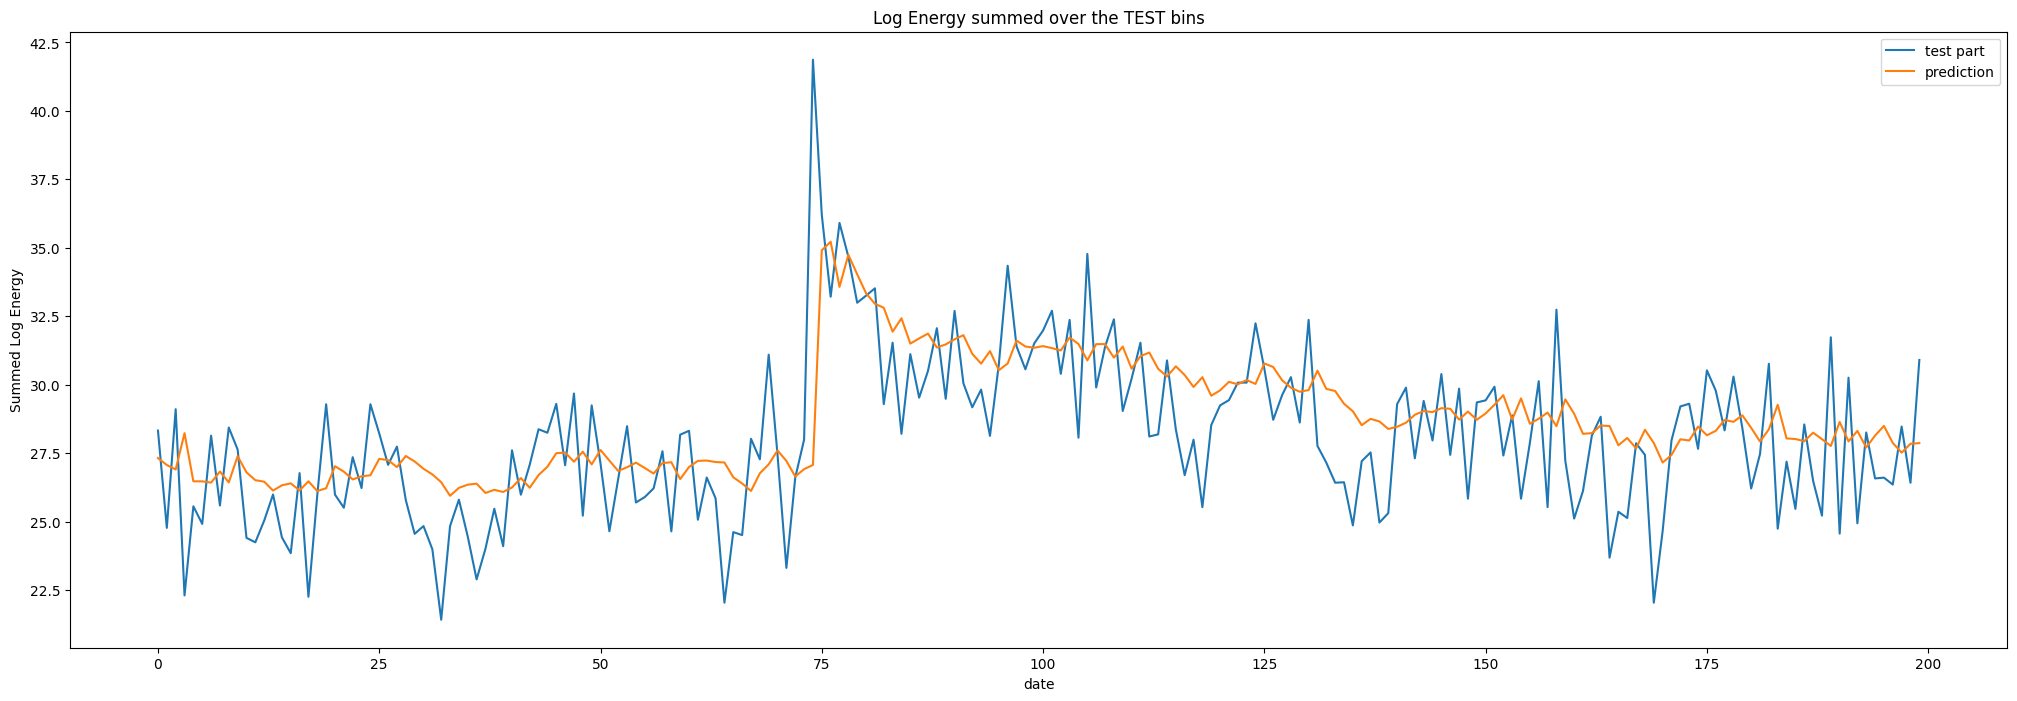

In [9]:

test_actual_y = true_labels_test.sum(axis=0)
test_predicted_y = predictions.sum(axis=0)

# Setting up the plot
plt.figure(figsize=(25, 8))
# Plotting Training and Validation MAE
# plt.plot(index_date_train ,train_actual_y, label='train part')
plt.plot(test_actual_y, label='test part')
plt.plot(test_predicted_y, label='prediction')
plt.title('Log Energy summed over the TEST bins')
plt.xlabel('date')
plt.ylabel('Summed Log Energy')
# plt.grid()
plt.legend()
plt.show()
